# 08-2 합성곱 신경망을 사용한 이미지 분류

이번 절에서는 텐서플로 케라스 API를 사용해 7장에서 만들었던 패션 MNIST 데이터를 합성곱 신경망으로 분류해 보겠습니다.

## 패션 MNIST 데이터 불러오기

패션 MNIST 데이터를 불러오고 전처리한다.

완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼쳐야 합니다.

다만 8장 1절에서 언급했듯이 입력 이미지는 항상 깊이(채널) 차원이 있어야 합니다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

이제 (48000, 28, 28) 크기인 train_input이 (48000, 28, 28, 1) 크기인 train_scaled가 되었습니다.

## 합성곱 신경망 만들기

먼저 Sequential 클래스의 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가합니다.

In [2]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

첫 번째 층에서 입력의 차원을 지정해 주어야 합니다. input_shape 매개변수를 (28, 28, 1)로 지정한다.

그다음 풀링 층을 추가한다.

In [3]:
model.add(keras.layers.MaxPooling2D(2))

패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일합니다. 그다음 (2, 2) 풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어듭니다. 합성곱 층에서 32개의 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 됩니다. 따라서최대 풀링을 통과한 특성 맵의 크기는 (14, 14, 32)가 될 것입니다.

첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층을 추가해 보겠습니다.

In [4]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(2))

풀링 층에서 크기를 절반으로 줄인다. 64개의 필터를 사용했으므로 최종적으로 만들어지는 특성 맵의 크기는 (7, 7, 64)가 될 것입니다.

이제 이 3차원 특성 맵을 일렬로 펼칠 차례입니다. 이렇게 하는 이유는 마지막에 10개의 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문입니다.

In [5]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

은닉층과 출력층 사이에 드롭아웃을 넣었습니다.

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               313700    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0

모델 파라미터의 개수를 계산해 보죠.

케라스는 summary() 메서드 외에 층의 구성을 그림으로 표현해 주는 plot_model() 함수를 keras.utils 패키지에서 제공합니다.

In [7]:
keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [8]:
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


지금까지 만든 신경망을 그림으로 다시 살펴보도록 하겠습니다.

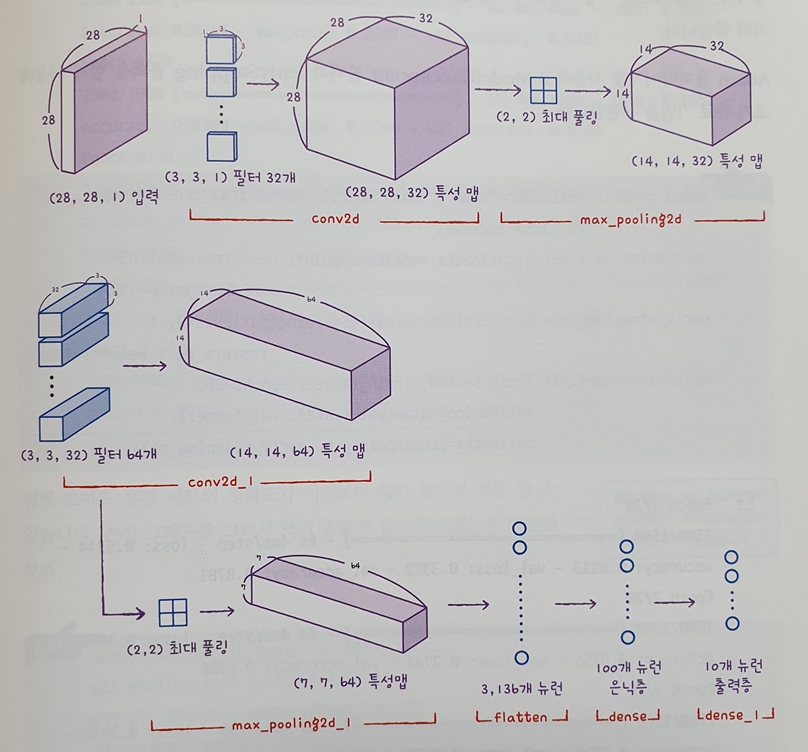

## 모델 컴파일과 훈련

Adam 옵티마이저를 사용하고 ModelCheckpoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법을 구현합니다.

In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=20, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 24s 15ms/step - loss: 0.5073 - accuracy: 0.8178 - val_loss: 0.3262 - val_accuracy: 0.8813
Epoch 2/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3354 - accuracy: 0.8810 - val_loss: 0.3043 - val_accuracy: 0.8845
Epoch 3/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2876 - accuracy: 0.8969 - val_loss: 0.2504 - val_accuracy: 0.9072
Epoch 4/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2578 - accuracy: 0.9062 - val_loss: 0.2529 - val_accuracy: 0.9056
Epoch 5/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2366 - accuracy: 0.9128 - val_loss: 0.2321 - val_accuracy: 0.9138
Epoch 6/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2155 - accuracy: 0.9211 - val_loss: 0.2265 - val_accuracy: 0.9171
Epoch 7/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.1997 - accuracy: 0.9252 - val_loss: 0.2256 -

얼핏 보아도 훈련 세트의 정확도가 이전보다 훨씬 좋아진 것을 알 수 있습니다. 손실 그래프를 그려서 조기 종료가 잘 이루어졌는지 확인해 보죠.

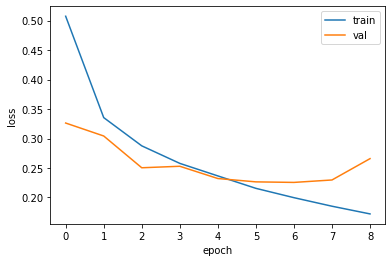

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작하고 훈련 세트에 대한 손실은 점점 더 낮아지고 있습니다.

EarlyStopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적의 모델 파라미터로 복원되어 있습니다.

In [11]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 5ms/step - loss: 0.2256 - accuracy: 0.9183


[0.22555960714817047, 0.9183333516120911]

predict() 메서드를 사용해 훈련된 모델을 사용하여 새로운 데이터에 대해 예측을 만들어 보겠습니다.

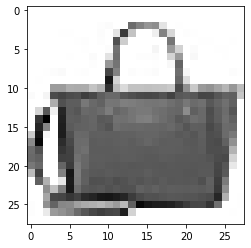

In [12]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

모델은 이 이미지에 대해 어떤 예측을 만드는지 확인해 보죠.

In [13]:
preds = model.predict(val_scaled[0:1])
preds

array([[7.0437672e-18, 1.7192807e-27, 2.0263162e-21, 6.9075247e-19,
        7.2974701e-19, 1.7705309e-19, 2.8597057e-18, 3.8061755e-21,
        1.0000000e+00, 1.8625201e-20]], dtype=float32)

> **왜 슬라이싱을 사용했나요?**   
> 케라스의 fit(), predict(), evaluate() 메서드는 모두 입력의 첫 번째 차원이 배치 차원일 것으로 기대합니다. 따라서 샘플 하나를 전달할 때 (28, 28, 1)이 아니라 (1, 28, 28, 1) 크기를 전달해야 합니다. 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1, 28, 28, 1) 크기를 만듭니다.

출력 결과를 보면 아홉 번째 값이 1이고 다른 값은 거의 0에 가깝습니다.

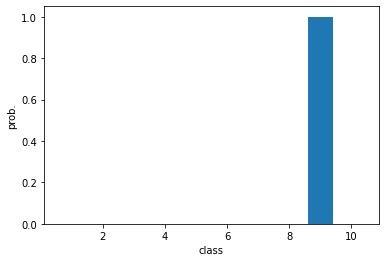

In [14]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

다른 클래스의 값은 사실상 모두 0입니다. 아홉 번째 클래스가 실제로 무엇인지는 패션 MNIST 데이터셋의 정의를 참고해야 합니다.

In [15]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [16]:
import numpy as np
classes[np.argmax(preds)]

'가방'

합성곱 신경망을 만들고 훈련하여 새로운 샘플에 대해 예측을 수행하는 방법도 알아보았습니다. 마지막으로 맨 처음에 떼어 놓았던 테스트 세트로 합성곱 신경망의 일반화 성능을 가늠해 보겠습니다.

In [17]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [18]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 2s 5ms/step - loss: 0.2486 - accuracy: 0.9131


[0.24864943325519562, 0.913100004196167]

91% 성능을 기대할 수 있겠군요!

## 마무리

### 핵심 포인트

- 텐서플로의 **Conv2D, MaxPooling2D, plot_model**를 활용한 실습

### 핵심 패키지와 함수

#### TensorFlow

- **Conv2D**: 입력의 너비와 높이 방향의 합성곱 연산을 구현한 클래스   
  첫 번째 매개변수는 합성곱 필터의 개수   
  kernel_size 매개변수는 필터의 커널 크기를 지정. 가로세로 크기가 같으면 정수 하나로, 다르면 정수의 튜플로 지정   
  strides 매개변수는 필터의 이동 간격 지정. 가로세로 크기가 같으면 정수 하나로, 다르면 정수의 튜플로 지정. 기본값 1   
  padding 매개변수는 입력의 패딩 타입 지정. 기본값 'valid'는 패딩을 하지 않음. 'same'은 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가   
  activation 매개변수는 합성곱 층에 적용할 활성화 함수 지정   
- **MaxPooling2D**: 입력의 너비와 높이를 줄이는 풀링 연산을 구현한 클래스   
  첫 번째 매개변수는 풀링의 크기 지정, 가로세로 크기가 같으면 정수 하나로, 다르면 정수의 튜플로 지정.   
  strides 매개변수는 풀링의 이동 간격 지정. 기본값은 풀링의 크기와 동일   
  padding 매개변수는 입력의 패딩 타입 지정.  기본값 'valid'는 패딩을 하지 않음. 'same'은 합성곱 층의 출력의 가로세로 크기를 입력과 동일하게 맞추도록 입력에 패딩을 추가   
- **plot_model()**: 케라스 모델 구조를 주피터 노트북에 그리거나 파일로 저장.   
  첫 번째 매개변수에 케라스 모델 객체 전달.
  to_file 매개변수에 파일 이름을 지정파면 그림 파일로 저장   
  show_shapes 매개변수를 True로 지정하면 층의 입력, 출력 크기를 표시. 기본값 False   
  show_layer_names 매개변수를 True로 지정하면 층 이름 출력. 기본값 True   

#### matplotlib

- **bar()**: 막대그래프 출력
  첫 번째 매개변수에 x축의 값을 리스트나 넘파이 배열로 전달
  두 번째 매개변수에 막대의 y축 값을 리스트나 넘파이 배열로 전달
  width 매개변수에 막대의 두께 지정. 기본값 0.8